In [1]:
import pandas as pd
import numpy as np

# Data
import yfinance as yf

# Statistics
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

# Plotting
import matplotlib.pyplot as plt

# Other
from itertools import combinations

In [2]:
tickers = ["HSBA.L", "BARC.L", "LLOY.L", "RIO.L", "BHP.L", "GLEN.L"]

# Daily close price download
data = yf.download(
    tickers,
    start="2017-01-01",
    end="2025-11-22",
    auto_adjust=True
)["Close"]

data.head()

[*********************100%***********************]  6 of 6 completed


Ticker,BARC.L,BHP.L,GLEN.L,HSBA.L,LLOY.L,RIO.L
Date,,,,,,
2017-01-03,231.320419,1322.512207,284.309448,662.672058,64.374931,3114.864990
2017-01-04,234.412689,1304.626831,281.769165,666.951843,64.524353,3088.548096
2017-01-05,231.968811,1308.104370,289.738525,658.392212,64.404823,3089.044434
2017-01-06,234.662064,1308.601196,287.347748,665.857056,65.650085,3073.650879
2017-01-09,233.465073,1331.951294,297.558624,665.757263,64.972664,3111.389160


In [3]:
# Remove days where we don't have all prices
prices = data.dropna()

# Convert to log prices
log_prices = np.log(prices)

log_prices.head()

Ticker,BARC.L,BHP.L,GLEN.L,HSBA.L,LLOY.L,RIO.L
Date,,,,,,
2017-01-03,5.443804,7.187288,5.650063,6.496280,4.164724,8.043941
2017-01-04,5.457083,7.173672,5.641088,6.502718,4.167043,8.035456
2017-01-05,5.446603,7.176334,5.668979,6.489801,4.165189,8.035617
2017-01-06,5.458146,7.176714,5.660693,6.501075,4.184339,8.030621
2017-01-09,5.453032,7.194400,5.695611,6.500925,4.173967,8.042825


In [4]:
results = []

# Test every pair of stocks to see which are cointegrated using the Engle-Granger Test
for a, b in combinations(log_prices.columns, 2):
    series_a = log_prices[a]
    series_b = log_prices[b]
    
    coint_t, p_value, _ = coint(series_a, series_b)
    
    results.append({
        "stock_a": a,
        "stock_b": b,
        "p_value": p_value,
        "coint_t": coint_t
    })

coint_results = pd.DataFrame(results).sort_values("p_value")
coint_results.head(10)

,stock_a,stock_b,p_value,coint_t
8,BHP.L,RIO.L,0.103551,-3.028652
12,HSBA.L,LLOY.L,0.106973,-3.013749
7,BHP.L,LLOY.L,0.345960,-2.356014
5,BHP.L,GLEN.L,0.348214,-2.351379
6,BHP.L,HSBA.L,0.398576,-2.250342
2,BARC.L,HSBA.L,0.535686,-1.986311
14,LLOY.L,RIO.L,0.620694,-1.818498
10,GLEN.L,LLOY.L,0.689826,-1.671423
9,GLEN.L,HSBA.L,0.699786,-1.648968
3,BARC.L,LLOY.L,0.737318,-1.560383


In [5]:
# Choose the most cointegrated pair (lowest p value)

best_pair = coint_results.iloc[0]
best_pair

stock_a       BHP.L
stock_b       RIO.L
p_value    0.103551
coint_t   -3.028652
Name: 8, dtype: object

In [6]:
# Regress A on B to find relationship

stock_a = best_pair["stock_a"]
stock_b = best_pair["stock_b"]

y = log_prices[stock_a]
x = log_prices[stock_b]

x_const = sm.add_constant(x)
model = sm.OLS(y, x_const).fit()
beta = model.params[stock_b] # How many units of B hedge 1 unit of A
alpha = model.params["const"]

beta, alpha

(np.float64(1.107552882112631), np.float64(-1.797839957069713))

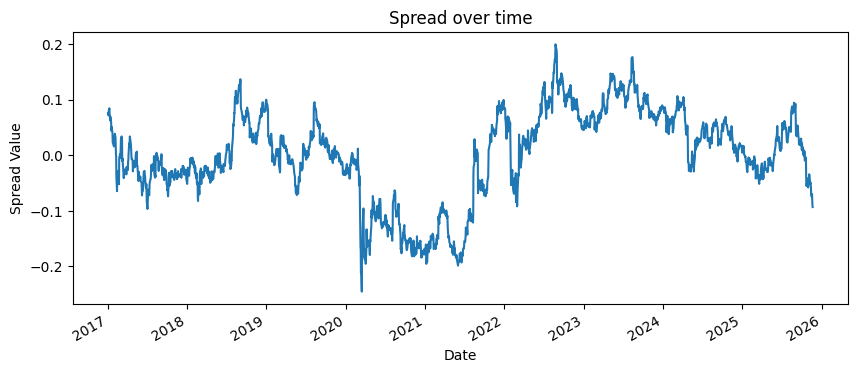

In [7]:
# Build the spread

spread = y - (alpha + beta * x)
spread.name = f"{stock_a}-{stock_b} spread"

# Visualise the spread
spread.plot(figsize=(10, 4))
plt.title("Spread over time")
plt.xlabel("Date")
plt.ylabel("Spread Value")
plt.show()

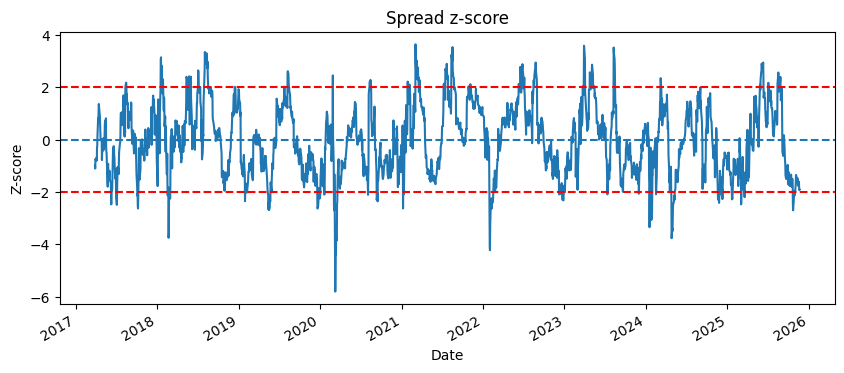

In [8]:
# Transform spread into a Z-score

window = 60  # Rolling mean/std for 60 days

spread_mean = spread.rolling(window).mean()
spread_std = spread.rolling(window).std()

zscore = (spread - spread_mean) / spread_std # How many standard deviations away the spread is from its recent average

# Visualise Z-score
zscore.plot(figsize=(10, 4))
plt.axhline(0, linestyle="--")
plt.axhline(2, linestyle="--", color="red")
plt.axhline(-2, linestyle="--", color="red")
plt.title("Spread z-score")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.show()

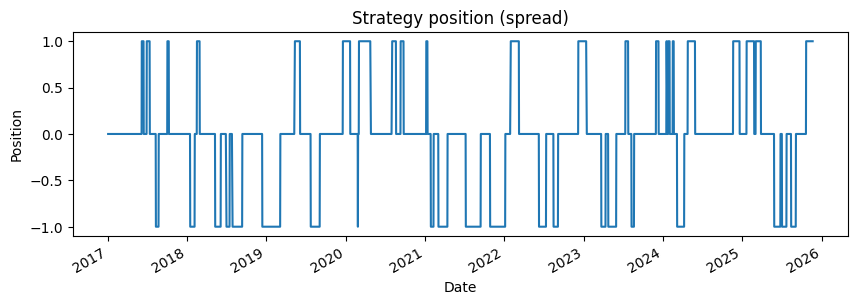

In [9]:
# Generating positions

position = pd.Series(0, index=zscore.index)

for t in range(1, len(zscore)):
    z = zscore.iloc[t]
    prev_pos = position.iloc[t-1]
    
    # We enter when Z-score is extreme
    if prev_pos == 0:
        if z < -2:
            position.iloc[t] = 1   # Long the spread (Buy A, sell 'beta' units of B)
        elif z > 2:
            position.iloc[t] = -1  # Short the spread (Sell A, buy 'beta' units of B)
        else:
            position.iloc[t] = 0
        # Position is 1, -1 or 0 every day
    
    # We exit when it comes back near 0
    else:
        if abs(z) < 0.5:
            position.iloc[t] = 0
        else:
            position.iloc[t] = prev_pos

position.plot(figsize=(10, 3))
plt.title("Strategy position (spread)")
plt.xlabel("Date")
plt.ylabel("Position")
plt.show()

In [10]:
# Spread daily return

spread_ret = spread.diff()  # Daily change in spread
spread_ret.name = "spread_ret"

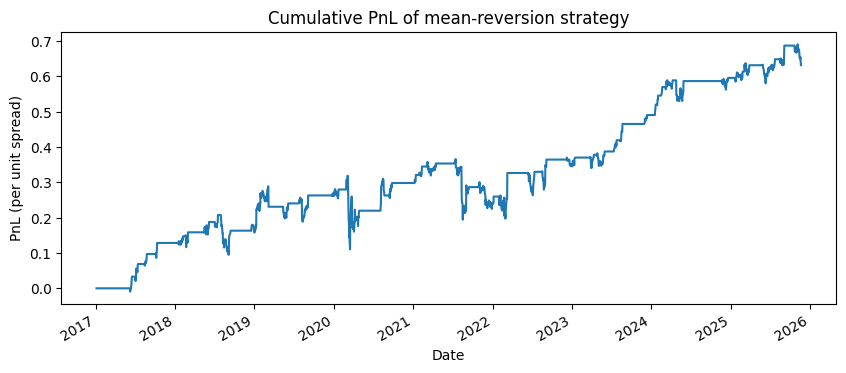

In [11]:
# Strategy PnL

strategy_ret = position.shift(1) * spread_ret  # Using yesterdays position (no lookahead bias)
strategy_ret.name = "strategy_ret"

cum_pnl = strategy_ret.cumsum() # Accumulation of returns over time

cum_pnl.plot(figsize=(10, 4))
plt.title("Cumulative PnL of mean-reversion strategy")
plt.xlabel("Date")
plt.ylabel("PnL (per unit spread)")
plt.show()

In [12]:
# Performance metrics

# Assuming 252 trading days per annum
ann_factor = np.sqrt(252)

# Annualised Sharpe ratio
sharpe = strategy_ret.mean() / strategy_ret.std() * ann_factor

# Sum of strategy daily returns
total_return = strategy_ret.cumsum().iloc[-1]

# Equity curve
equity_curve = (1 + strategy_ret).cumprod()

# Maximum Drawdown
running_max = equity_curve.cummax()
drawdown = (equity_curve / running_max) - 1
max_drawdown = drawdown.min()

# Display the metrics
print("Sharpe Ratio:", sharpe)
print("Total Return:", total_return)
print("Maximum Drawdown:", max_drawdown)

Sharpe Ratio: 0.5972908090742661
Total Return: 0.6315333215525456
Maximum Drawdown: -0.1937593805399429
